<a href="https://colab.research.google.com/github/panzershracker/Neural-networks-introducing/blob/master/NN_Intro_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта

  В качестве курсового проекта я выбрал не совсем стандартный (как мне кажется) способ применения полносвязной однослойной (?) сети. Об этом ниже.

  В качестве датасета я выбрал датасет из курсового проекта с курса 'python for data science 2', где необходимо было определить вернет ли клиент кредит или нет.
По курсовой было соревнование на платформе kaggle (https://www.kaggle.com/c/credit-default-prediction-ai-big-data/leaderboard).
В этом соревновании, на данный момент, я занимаю 13-е место с результатом 0.54141 (1-е место - 0.56277). В данном соревновании большинство (если не все) использовали бустинговые алгоритмы (в основном катбуст), как и я, и обучение и подгонка занимала довольно много времени, но нейросеть дала результат 0.37699 уже на несбалансированных данных, и мне кажется, что, при верной настройке - способна если не превзойти этот результат то хотя бы сравняться сним, при этом занимая меньше времени на обучение (очень хочется в это верить :) ).

  И так, основная идея моей работы заключалась в том, что, по сути, каждое наблюдение датасета это то же самое изображение в формате одномерного массива, которые мы после преобразования подаем в входной слой полносвязанной сети.
  
  Как только я добьюсь приемлемого результата по оценке - сравню скорость работы обоих вариантов, но для этого необходимо сбалансировать данные.
  Для балансировки попытаюсь применить метод Tomek links (все никак не доберусь до него), это андерсемплинговый метод, суть которого в том, чтобы удалять не рандомные значения, а те которые находятся на границе классов:
<img src='https://miro.medium.com/max/1400/0*YWVxE7SbWKnTnbZi'/>

Этот метод, как мне кажется, даст наиболее правдоподобную картину данных, в отличие от всевозможных оверсемплингов с синтетическими примерами. Т.е. датасет останется максимально чистым и не разбавленным.

Уже на данном этапе моя работа отвечает требованиям курсового проекта - я провел работу и убедился в работоспособности данного метода, теперь дело за хорошим результатом. Надеюсь он оправдает мои ожидания.

Датасет был предобработан мною ранее - как раз в проекте по предсказанию возврата кредита. Все преобразования датасета можно изучить по ссылке: 
https://github.com/panzershracker/Python-for-DS2/blob/master/AEvdokimov_solution.ipynb

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from matplotlib import pyplot as plt
import plotly.express as px

from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import textwrap

from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA

import warnings

warnings.simplefilter('ignore')

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Введение в нейронные сети/Курсовой проект/train_xtra_feats.csv')

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/Введение в нейронные сети/Курсовой проект/test_xtra_feats.csv')

In [0]:
df_train.head(3)

,Unnamed: 0,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term,0,1
0,0,-1.144868,-0.111778,-0.026399,1.133645,-0.002019,1.670729,2.545732,2.76052,-0.770558,-0.875552,-0.216799,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,-0.440916,-0.111778,0.790069,-0.428528,0.428723,-0.341874,-0.337099,-0.36362,0.335074,0.005506,-0.225139,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,2,-0.795969,-0.111778,-0.026399,2.369181,0.429335,-0.341874,-0.337099,2.76052,0.059663,-0.392272,-0.221664,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [0]:
df_test.head(3)

,Unnamed: 0,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term,0,1
0,0,-0.599059,-0.11632,-0.451849,-0.803220,-0.411914,-0.326739,-0.299225,-0.371832,-0.511337,-0.992788,-0.260150,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,-1.500132,-0.11632,-1.073547,1.981755,-0.554306,-0.326739,-0.299225,-0.374441,-0.672453,-1.382250,-0.274207,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2,-0.274189,-0.11632,-0.244617,-0.637776,-0.426038,-0.326739,-0.299225,-0.370663,-0.402120,0.039653,3.917859,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [0]:
# Уберем колонку "Unnamed:0"

df_train = df_train.drop(df_train.columns[0], axis=1)
df_test = df_test.drop(df_test.columns[0], axis=1)

#====================================================================


# Данный блок нужен для того, чтобы выяснить - целесообразно ли будет использовать андерсемплинг tomek links или нет. В случае неудовлетворительного результата данный кусок кода не будет использоваться в общих вычислениях

### Стандартизируем данные для PCA для отображения в 2-х мерном виде.

In [0]:
df_train = df_train.drop(columns='renewable energy')

In [0]:
# Отделим целевой признак от трейна.

X = df_train.loc[:, df_train.columns != 'Credit Default']
y = df_train['Credit Default']

In [0]:
X_standart = StandardScaler().fit_transform(X)

In [0]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standart)

In [0]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
pca_df_full = pd.concat([pca_df, y], axis=1)

In [0]:
fig = px.scatter(pca_df_full, 'PC1', 'PC2',
                 color='Credit Default', symbol='Credit Default', color_continuous_scale=[(0,'orange'), (1, 'blue')], opacity=.6,
                 height=500, width=500)

fig.show()

#! 
Возможно, в трехмерном отображении при 3-х компонентах будет более четкая граница между классами.

### Отобразим данные в 3-х мерном виде при помощи PCA.

In [0]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_standart)

In [0]:
pca_3_df = pd.DataFrame(data=X_pca_3, columns=['PC1','PC2','PC3'])
pca_3_df_full = pd.concat([pca_3_df, y], axis=1)

In [0]:
pca_3_df_full.head(1)

,PC1,PC2,PC3,Credit Default
0,-1.013759,-0.855715,2.915799,0


In [0]:
fig = px.scatter_3d(pca_3_df_full, x='PC1', y='PC2', z='PC3', 
                    color='Credit Default', symbol='Credit Default', color_continuous_scale=[(0,'orange'),(1,'blue')], opacity=1,
                    height=500, width=500)

fig.show()

#! 
Так как четкой границы между классами нет (в основной массе) - будем удалять образцы рандомно.

In [0]:
indices = pca_3_df_full.loc[pca_3_df_full['PC2'] > 6].index

#=========================  Конец тестового блока  ======================


In [0]:
# Делим на трейн и валид. Используем перемешивание и стратификацию.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=.2, random_state=21, stratify=y)

### Приведем данные к диапазону от 0 до 1.


In [0]:
scaler = MinMaxScaler()
df_train[:] = scaler.fit_transform(df_train[:])
df_test[:] = scaler.fit_transform(df_test[:])

In [0]:
df_train.head(3)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term,0,1
0,0.039911,0.0,0.250000,0.415270,0.027438,0.166667,0.25,1.000000,0.009477,0.07914,0.023682,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.108222,0.0,0.361111,0.210428,0.047269,0.000000,0.00,0.002538,0.078994,0.18373,0.021949,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.073768,0.0,0.250000,0.577281,0.047297,0.000000,0.00,1.000000,0.061678,0.13651,0.022671,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [0]:
df_test.head(3)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term,0,1
0,0.098844,0.0,0.216216,0.173737,0.008839,0.0,0.0,0.001471,0.021181,0.071901,0.019724,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.015443,0.0,0.135135,0.581818,0.002238,0.0,0.0,0.000629,0.009207,0.023806,0.016534,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.128913,0.0,0.243243,0.197980,0.008184,0.0,0.0,0.001848,0.029298,0.199397,0.968093,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Визуализация 3-х строк

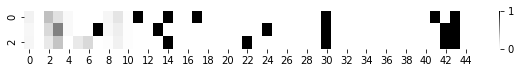

In [0]:
plt.figure(figsize=[10, 0.7])
sns.heatmap(df_train.loc[1:3].values, cmap='Greys')

plt.show()

### Отделим лейбл от тренировочного датасета и поделим его на тренировочный и валидационный


In [0]:
# Уберем лишний признак "renewable energy" т.к. его нет в df_test.

set(df_train.columns) - set(df_test.columns)

{'Credit Default'}

In [0]:
# df_train = df_train.drop(columns='renewable energy')

In [0]:
# Отделим целевой признак от трейна.

X = df_train.loc[:, df_train.columns != 'Credit Default']
y = df_train['Credit Default']

In [0]:
# Делим на трейн и валид. Используем перемешивание и стратификацию.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=.2, random_state=21, stratify=y)

In [0]:
X_train.shape, X_valid.shape, df_test.shape

((6000, 44), (1500, 44), (2500, 44))

### Проверка стратифицированности

In [0]:
((y_train.value_counts()[0] / y_train.value_counts()[1]).round(2), # соотношение лейбла в тестовом наборе
(y_valid.value_counts()[0] / y_valid.value_counts()[1]).round(2))  # соотношение лейбла в валидационном наборе

(2.55, 2.55)

### Undersampling tomek links


In [0]:
tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X_train, y_train)

In [0]:
from collections import Counter

In [0]:
print(f'Original dataset classes count is {Counter(y_train)}\n'
      f'Resampled dataset classes count is {Counter(y_tl)}')

Original dataset classes count is Counter({0.0: 4310, 1.0: 1690})
Resampled dataset classes count is Counter({0.0: 3860, 1.0: 1690})


#! 
Алгоритм андерсемплинга tomek links сократил кол-во нулевого (большего) класса примерно на 500 наблюдений.

Переназначим X_train и y_train.

In [0]:
X_train, y_train = X_tl, y_tl

### Определим наборы и для удобства назовем их images.

In [0]:
train_images = X_train
valid_images = X_valid.loc[:].values
test_images = df_test.loc[:].values

### Определим лейблы 


In [0]:
train_labels = y_train
valid_labels = y_valid.values

#! 
Так как андерсемплинг убрал недостаточно наблюдений и дисбаланс сохраняется - используем функцию (самописную) балансировки классов.

In [0]:
#  Соберем готовые тренировочные данные (наблюдения и лейблы) в новый датафрейм

train_images_df = pd.DataFrame(train_images, columns=X_valid.columns)
train_labels_df = pd.DataFrame(train_labels, columns=['Credit Default'])

In [0]:
balanced_df = pd.concat([train_images_df, train_labels_df], axis=1)

In [0]:
# Функция балансировки классов

def balance(df, target):
  
  target_counts = df[target].value_counts()
  
  major = target_counts.argmax()
  minor = target_counts.argmin()
  
  disbalance_coef = target_counts[major] - target_counts[minor]
  
  for i in range(0, disbalance_coef):
    sample = df[df[target] == minor].sample()
    df = df.append(sample, ignore_index=True)
  
  return df.sample(frac=1)
  

In [0]:
# Балансируем

balanced_df = balance(balanced_df, 'Credit Default')

In [0]:
balanced_df['Credit Default'].value_counts()

1.0    3860
0.0    3860
Name: Credit Default, dtype: int64

In [0]:
# Разбираем датафрейм обратно.

train_images = balanced_df.loc[:, balanced_df.columns != 'Credit Default'].values
train_labels = balanced_df['Credit Default'].values

### Построение модели

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [0]:
# Build the model.
model = Sequential([
  Dense(44, activation='relu', input_shape=(44,)),
  Dense(88, activation='relu'),
  Dense(176, activation='relu'),
  Dense(352, activation='relu'),
  Dense(176, activation='relu'),
  Dense(88, activation='relu'),
  Dense(44, activation='relu'),
  Dense(22, activation='relu'),
  Dense(10, activation='relu'),
  Dense(6, activation='relu'),
  Dense(2, activation='softmax'),
])

In [0]:
# Compile the model.
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [0]:
# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=18,
  batch_size=48,
)


Epoch 1/18
7720/7720 [==============================] - 1s 109us/step - loss: 0.6927 - accuracy: 0.5181
Epoch 2/18
7720/7720 [==============================] - 1s 72us/step - loss: 0.6917 - accuracy: 0.5650
Epoch 3/18
7720/7720 [==============================] - 1s 68us/step - loss: 0.6907 - accuracy: 0.6047
Epoch 4/18
7720/7720 [==============================] - 1s 69us/step - loss: 0.6884 - accuracy: 0.6214
Epoch 5/18
7720/7720 [==============================] - 1s 67us/step - loss: 0.6853 - accuracy: 0.6381
Epoch 6/18
7720/7720 [==============================] - 1s 67us/step - loss: 0.6806 - accuracy: 0.6409
Epoch 7/18
7720/7720 [==============================] - 1s 70us/step - loss: 0.6736 - accuracy: 0.6516
Epoch 8/18
7720/7720 [==============================] - 1s 69us/step - loss: 0.6635 - accuracy: 0.6523
Epoch 9/18
7720/7720 [==============================] - 1s 72us/step - loss: 0.6507 - accuracy: 0.6552
Epoch 10/18
7720/7720 [==============================] - 1s 72us/step - 

### Тестовые результаты предсказания лейблов для первых пяти элементов валидационной выборки

In [0]:
test_predictions = model.predict(valid_images[:5])
print(f'predicted labels for first 5 images is {np.argmax(test_predictions, axis=1)}')
print(f'true labels for first 5 images is {valid_labels[:5]}')

predicted labels for first 5 images is [0 0 0 1 0]
true labels for first 5 images is [0. 0. 0. 0. 0.]


### Получим предикт всего валидационного набора.

In [0]:
train_pred = np.argmax(model.predict(train_images), axis=1)
valid_pred = np.argmax(model.predict(valid_images), axis=1)

### Расчитаем F1 score

In [0]:
from sklearn.metrics import classification_report, f1_score

In [0]:
print(f'Train_images result is: \n\n {classification_report(train_labels, train_pred)}')
print(f'OVERALL train F1 is: {(f1_score(train_labels, train_pred).round(5))}\n\n')
print(f'Valid_images result is: \n\n {classification_report(valid_labels, valid_pred)}')
print(f'OVERALL valid F1 is: {(f1_score(valid_labels, valid_pred).round(5))}')

Train_images result is: 

               precision    recall  f1-score   support

         0.0       0.63      0.86      0.73      3860
         1.0       0.78      0.49      0.60      3860

    accuracy                           0.68      7720
   macro avg       0.70      0.68      0.66      7720
weighted avg       0.70      0.68      0.66      7720

OVERALL train F1 is: 0.60295


Valid_images result is: 

               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      1077
         1.0       0.53      0.46      0.49       423

    accuracy                           0.73      1500
   macro avg       0.66      0.65      0.65      1500
weighted avg       0.72      0.73      0.72      1500

OVERALL valid F1 is: 0.4899


1. train F1 is: 0.45079, valid F1 is: 0.37983
2. train F1 is: 0.406, valid F1 is: 0.38406
3. train F1 is: 0.51418, valid F1 is: 0.38328
4. train F1 is: 0.54007, valid F1 is: 0.48889
5. train F1 is: 0.50977, valid F1 is: 0.39103, sub = 0.37699
6. train F1 is: 0.56252, valid F1 is: 0.41818, sub = 0.37974
7. train F1 is: 0.54666, valid F1 is: 0.46154 
8. train F1 is: 0.71757, valid F1 is: 0.50644, sub = 0.48813
9. train F1 is: 0.84283, valid F1 is: 0.52098, sub = 0.46990

### Предикт класса для тестовой выборки и сохранение результата.


In [0]:
test_pred = np.argmax(model.predict(test_images), axis=1)

In [0]:
df_test['id'] = df_test.index + 7500
submit_df = pd.DataFrame({'id':df_test['id'], 'Credit Default':test_pred}, dtype=np.int32)
submit_df.to_csv('/content/drive/My Drive/Введение в нейронные сети/Курсовой проект/Predictions/Evdokimov_predictions_4.csv', index=False)
df_test = df_test.drop('id', axis=1)

#! 
### Заметка

В официальной документации по функциям потерь для функции categorical_crossentropy указано, что ее лучше использовать для лейблов закодированных в one-hot, в иных случаях лучше использовать SparseCategoricalCrossentropy. Так же для двух лейблов лучше использовать бинарную кроссэнтропию.
В действительности же мы имеем лучший скор с функцией categorical_crossentropy, где лейблы не закодированны, а представленны в виде int.

# TODO:
+ Балансировка классов (попробовать наконец tomek links)
- сделать лог результатов и параметров в текстовый документ для воспроизводимости

# Вывод:

На данный момент не получается предиктить лучше чем 0.488, вернусь к этому проекту позже.